# Insgesamt Accidents Analysis and Modeling

In this notebook, I proposed a solution for forecasting the 'Insgesamt' category from Verkehrsunfälle accidents type in Munich accidents dataset. In this dataset, there are 4 categories of accidents.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Preparing, cleaning, analyzing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 
seed_number = 42
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

## Data Preparation

In [2]:
df = pd.read_csv('./data/clean_munic_accidents.csv', index_col='date')

In [3]:
df.head()

,category,accident_type,year,month,value
date,,,,,
2000-01-01,Fluchtunfälle,Verletzte und Getötete,2000,1,34
2000-01-01,Verkehrsunfälle,mit Personenschäden,2000,1,321
2000-01-01,Alkoholunfälle,insgesamt,2000,1,78
2000-01-01,Fluchtunfälle,insgesamt,2000,1,835
2000-01-01,Verkehrsunfälle,insgesamt,2000,1,3448


In [4]:
#Extracting the Alkoholunfälle
df = df[df.category == 'Alkoholunfälle']

In [5]:
#Extracting the insgesamt data

df = df[df.accident_type == 'insgesamt']

## Data Assesment

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category       252 non-null    object
 1   accident_type  252 non-null    object
 2   year           252 non-null    int64 
 3   month          252 non-null    int64 
 4   value          252 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 11.8+ KB


In [7]:
df.head(15)

,category,accident_type,year,month,value
date,,,,,
2000-01-01,Alkoholunfälle,insgesamt,2000,1,78
2000-02-01,Alkoholunfälle,insgesamt,2000,2,53
2000-03-01,Alkoholunfälle,insgesamt,2000,3,73
2000-04-01,Alkoholunfälle,insgesamt,2000,4,78
2000-05-01,Alkoholunfälle,insgesamt,2000,5,96
2000-06-01,Alkoholunfälle,insgesamt,2000,6,57
2000-07-01,Alkoholunfälle,insgesamt,2000,7,99
2000-08-01,Alkoholunfälle,insgesamt,2000,8,77
2000-09-01,Alkoholunfälle,insgesamt,2000,9,84


In [8]:
df.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Here, All the values are proper Numbers except the 1st value

In [9]:
df.year.unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int64)

Year column has incorrect datatype

In [10]:

df.accident_type.unique()

array(['insgesamt'], dtype=object)

## Cleaning
From above analysis I decided the follwoing:
- Remove accident_type, category
- Sort the values to have a sorted values according to the date column.

### Remove accident_type, category

In [11]:
df.drop(columns=['accident_type', 'category'], inplace=True, axis=1)

### Sorting values accordiing to the date

In [12]:
df.sort_values(['date'], inplace=True, ascending=True)

## Analyzing Data

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2000-01-01 to 2020-12-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    252 non-null    int64
 1   month   252 non-null    int64
 2   value   252 non-null    int64
dtypes: int64(3)
memory usage: 7.9+ KB


In [14]:
df.head()

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96


Text(0.5, 1.0, 'Accidents per year')

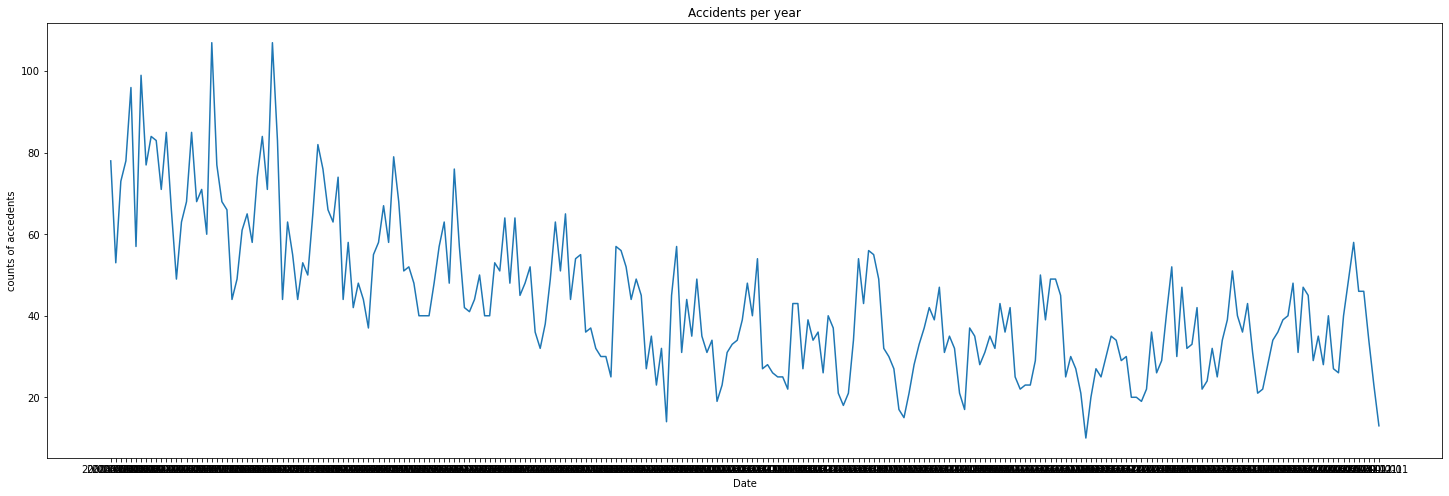

In [15]:
plt.figure(figsize=(25,8))
plt.plot( df.groupby(by =['date'])['value'].sum())
plt.xlabel('Date')
plt.ylabel('counts of accedents')
plt.title('Accidents per year')


In [16]:
acc_coun_per_month = [i for i in df.groupby(df.month)['value'].sum()]

Text(0.5, 1.0, 'Accidents per months from 2000 to 2020')

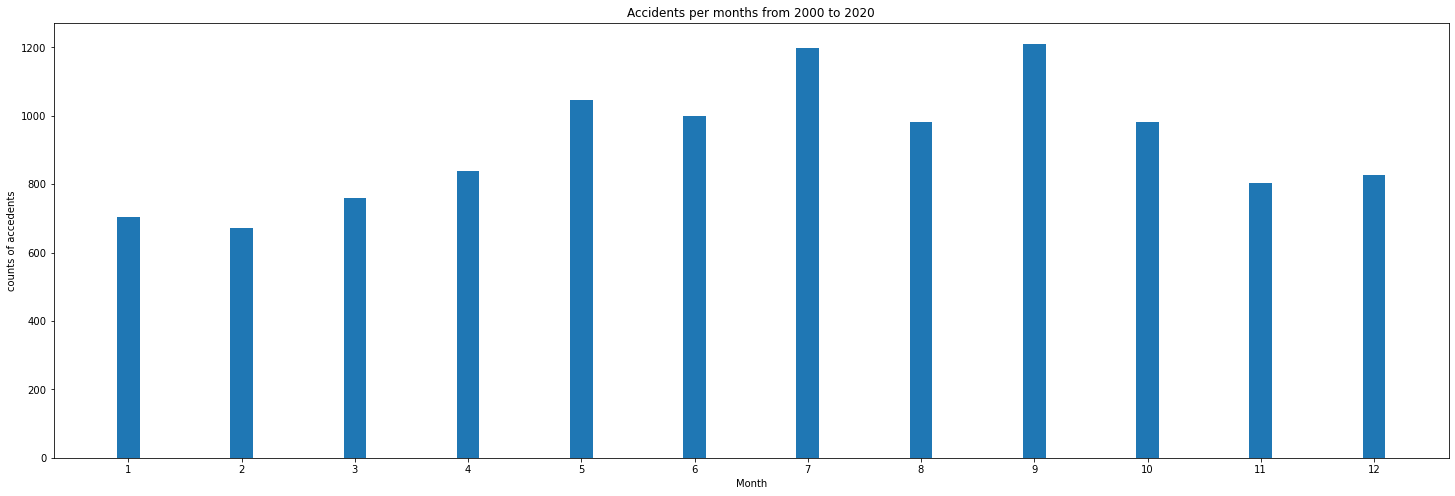

In [17]:
plt.figure(figsize=(25,8))
plt.xticks(range(len(df.month)), df.month)
width = 0.2
plt.bar(np.arange(len(acc_coun_per_month)), acc_coun_per_month, width=width)

plt.xlabel('Month')
plt.ylabel('counts of accedents')
plt.title('Accidents per months from 2000 to 2020')




We notice July month has the highest number of accidents and the least month is Jan

## Preprocessing

- Splitting Data into training and testing.
- Data Normalization.
- Preparing LSTM subsequences

### Splitting Data into training and testing

In [18]:
df

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96
...,...,...,...
2020-08-01,2020,8,46
2020-09-01,2020,9,46
2020-10-01,2020,10,34


In [19]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
train, test = train_test_split(df, test_size=0.1, shuffle = False)



In [20]:
train[0:20]

,year,month,value
date,,,
2000-01-01,2000,1,78
2000-02-01,2000,2,53
2000-03-01,2000,3,73
2000-04-01,2000,4,78
2000-05-01,2000,5,96
2000-06-01,2000,6,57
2000-07-01,2000,7,99
2000-08-01,2000,8,77
2000-09-01,2000,9,84


In [21]:
test.head()

,year,month,value
date,,,
2018-11-01,2018,11,31
2018-12-01,2018,12,21
2019-01-01,2019,1,22
2019-02-01,2019,2,28
2019-03-01,2019,3,34


In [22]:
train.shape, test.shape

((226, 3), (26, 3))

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226 entries, 2000-01-01 to 2018-10-01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    226 non-null    int64
 1   month   226 non-null    int64
 2   value   226 non-null    int64
dtypes: int64(3)
memory usage: 7.1+ KB


### Data Normalization

In [24]:
f_scaler = RobustScaler()
cnt_scaler = RobustScaler()

#Features columns
f_columns = ['year', 'month']


# Fit the training
f_transformer = f_scaler.fit(train[f_columns].to_numpy())

#Transform the training
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())




cnt__transformer = cnt_scaler.fit(train[['value']])
#For output column
train['value'] = cnt__transformer.transform(train[['value']])
test['value'] = cnt__transformer.transform(test[['value']])


### Preparing LSTM subsequences

In [70]:
def creat_ds(x,y, time_step=1):
    #Create x series and y series to hold sequences
    xs, ys = [], []
    #print(x)
    #print()
    #print(y)
    for i in range(len(x) - time_step):
        #print('***')
        #Extract the sequence
        v = x.iloc[i: (i+time_step)].to_numpy()
        #append it into x series
        xs.append(v)
        
        #Repeat all above for y series
        ys.append(y.iloc[i+time_step])
    return np.array(xs), np.array(ys)   
    

In [26]:
#I will use the previous 5 months data to know the future data
#['category', 'accident_type', 'year', 'month']
Time_Step = 12
xs_train, ys_train = creat_ds(train, train.value, time_step=Time_Step)


xs_test, ys_test = creat_ds(test, test.value, time_step=Time_Step)

In [27]:
xs_train.shape, xs_test.shape

((214, 12, 3), (14, 12, 3))

In [28]:
ys_train.shape, ys_test.shape 

((214,), (14,))

In [29]:
xs_train.shape[1],xs_train.shape[2] 

(12, 3)

In [30]:
xs_train[0]

array([[-0.9       , -0.86956522,  1.5       ],
       [-0.9       , -0.69565217,  0.45833333],
       [-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667]])

In [31]:
xs_train[1]

array([[-0.9       , -0.69565217,  0.45833333],
       [-0.9       , -0.52173913,  1.29166667],
       [-0.9       , -0.34782609,  1.5       ],
       [-0.9       , -0.17391304,  2.25      ],
       [-0.9       ,  0.        ,  0.625     ],
       [-0.9       ,  0.17391304,  2.375     ],
       [-0.9       ,  0.34782609,  1.45833333],
       [-0.9       ,  0.52173913,  1.75      ],
       [-0.9       ,  0.69565217,  1.70833333],
       [-0.9       ,  0.86956522,  1.20833333],
       [-0.9       ,  1.04347826,  1.79166667],
       [-0.8       , -0.86956522,  1.        ]])

In [32]:
ys_train[0]

1.0

## Modeling

In [33]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

model = keras.Sequential()
model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(64,input_shape = (xs_train.shape[1], xs_train.shape[2]))))

model.add(tf.keras.layers.Dense(units=1))

In [34]:
model.compile(loss = 'mse', optimizer=keras.optimizers.Adam(0.000001))

In [ ]:
model.summary()

In [35]:
history = model.fit(xs_train, ys_train, epochs=10000, batch_size=4, validation_split=0.25,
                    shuffle=False, callbacks=[mc, es])

Epoch 1/10000
40/40 [==============================] - 3s 35ms/step - loss: 0.7152 - val_loss: 0.4718

Epoch 00001: saving model to best_model.h5
Epoch 2/10000
40/40 [==============================] - 1s 28ms/step - loss: 0.7140 - val_loss: 0.4710

Epoch 00002: saving model to best_model.h5
Epoch 3/10000
40/40 [==============================] - 1s 31ms/step - loss: 0.7127 - val_loss: 0.4701

Epoch 00003: saving model to best_model.h5
Epoch 4/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.7114 - val_loss: 0.4692

Epoch 00004: saving model to best_model.h5
Epoch 5/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.7101 - val_loss: 0.4683

Epoch 00005: saving model to best_model.h5
Epoch 6/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.7088 - val_loss: 0.4674

Epoch 00006: saving model to best_model.h5
Epoch 7/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.7074 - val_loss: 0.4665

Epoch 00007: saving m

40/40 [==============================] - 1s 34ms/step - loss: 0.6421 - val_loss: 0.4229

Epoch 00057: saving model to best_model.h5
Epoch 58/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.6409 - val_loss: 0.4221

Epoch 00058: saving model to best_model.h5
Epoch 59/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.6396 - val_loss: 0.4213

Epoch 00059: saving model to best_model.h5
Epoch 60/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.6384 - val_loss: 0.4204

Epoch 00060: saving model to best_model.h5
Epoch 61/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.6371 - val_loss: 0.4196

Epoch 00061: saving model to best_model.h5
Epoch 62/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.6359 - val_loss: 0.4188

Epoch 00062: saving model to best_model.h5
Epoch 63/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.6347 - val_loss: 0.4180

Epoch 00063: saving model to 

Epoch 113/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.5760 - val_loss: 0.3786

Epoch 00113: saving model to best_model.h5
Epoch 114/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.5749 - val_loss: 0.3779

Epoch 00114: saving model to best_model.h5
Epoch 115/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.5737 - val_loss: 0.3771

Epoch 00115: saving model to best_model.h5
Epoch 116/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.5726 - val_loss: 0.3764

Epoch 00116: saving model to best_model.h5
Epoch 117/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.5715 - val_loss: 0.3757

Epoch 00117: saving model to best_model.h5
Epoch 118/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.5704 - val_loss: 0.3749

Epoch 00118: saving model to best_model.h5
Epoch 119/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.5693 - val_loss: 0.3742

Epoch 0

40/40 [==============================] - 1s 33ms/step - loss: 0.4650 - val_loss: 0.3041

Epoch 00223: saving model to best_model.h5
Epoch 224/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.4641 - val_loss: 0.3035

Epoch 00224: saving model to best_model.h5
Epoch 225/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.4632 - val_loss: 0.3029

Epoch 00225: saving model to best_model.h5
Epoch 226/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.4623 - val_loss: 0.3023

Epoch 00226: saving model to best_model.h5
Epoch 227/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.4615 - val_loss: 0.3017

Epoch 00227: saving model to best_model.h5
Epoch 228/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.4606 - val_loss: 0.3011

Epoch 00228: saving model to best_model.h5
Epoch 229/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.4597 - val_loss: 0.3005

Epoch 00229: saving mod

40/40 [==============================] - 1s 35ms/step - loss: 0.3795 - val_loss: 0.2458

Epoch 00333: saving model to best_model.h5
Epoch 334/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.3788 - val_loss: 0.2454

Epoch 00334: saving model to best_model.h5
Epoch 335/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.3782 - val_loss: 0.2449

Epoch 00335: saving model to best_model.h5
Epoch 336/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.3775 - val_loss: 0.2444

Epoch 00336: saving model to best_model.h5
Epoch 337/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.3769 - val_loss: 0.2440

Epoch 00337: saving model to best_model.h5
Epoch 338/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.3762 - val_loss: 0.2435

Epoch 00338: saving model to best_model.h5
Epoch 339/10000
40/40 [==============================] - 2s 45ms/step - loss: 0.3756 - val_loss: 0.2431

Epoch 00339: saving mod

40/40 [==============================] - 1s 34ms/step - loss: 0.3202 - val_loss: 0.2037

Epoch 00443: saving model to best_model.h5
Epoch 444/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.3198 - val_loss: 0.2034

Epoch 00444: saving model to best_model.h5
Epoch 445/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.3193 - val_loss: 0.2031

Epoch 00445: saving model to best_model.h5
Epoch 446/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.3189 - val_loss: 0.2028

Epoch 00446: saving model to best_model.h5
Epoch 447/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.3185 - val_loss: 0.2025

Epoch 00447: saving model to best_model.h5
Epoch 448/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.3181 - val_loss: 0.2022

Epoch 00448: saving model to best_model.h5
Epoch 449/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.3177 - val_loss: 0.2019

Epoch 00449: saving mod

40/40 [==============================] - 1s 36ms/step - loss: 0.2844 - val_loss: 0.1766

Epoch 00553: saving model to best_model.h5
Epoch 554/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2842 - val_loss: 0.1764

Epoch 00554: saving model to best_model.h5
Epoch 555/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2839 - val_loss: 0.1762

Epoch 00555: saving model to best_model.h5
Epoch 556/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2837 - val_loss: 0.1760

Epoch 00556: saving model to best_model.h5
Epoch 557/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2834 - val_loss: 0.1758

Epoch 00557: saving model to best_model.h5
Epoch 558/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2832 - val_loss: 0.1757

Epoch 00558: saving model to best_model.h5
Epoch 559/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2830 - val_loss: 0.1755

Epoch 00559: saving mod

40/40 [==============================] - 1s 37ms/step - loss: 0.2633 - val_loss: 0.1605

Epoch 00663: saving model to best_model.h5
Epoch 664/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2632 - val_loss: 0.1604

Epoch 00664: saving model to best_model.h5
Epoch 665/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2630 - val_loss: 0.1603

Epoch 00665: saving model to best_model.h5
Epoch 666/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2629 - val_loss: 0.1602

Epoch 00666: saving model to best_model.h5
Epoch 667/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2627 - val_loss: 0.1600

Epoch 00667: saving model to best_model.h5
Epoch 668/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2625 - val_loss: 0.1599

Epoch 00668: saving model to best_model.h5
Epoch 669/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2624 - val_loss: 0.1598

Epoch 00669: saving mod

40/40 [==============================] - 1s 35ms/step - loss: 0.2484 - val_loss: 0.1506

Epoch 00773: saving model to best_model.h5
Epoch 774/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2483 - val_loss: 0.1506

Epoch 00774: saving model to best_model.h5
Epoch 775/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2482 - val_loss: 0.1505

Epoch 00775: saving model to best_model.h5
Epoch 776/10000
40/40 [==============================] - 1s 32ms/step - loss: 0.2481 - val_loss: 0.1504

Epoch 00776: saving model to best_model.h5
Epoch 777/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2480 - val_loss: 0.1503

Epoch 00777: saving model to best_model.h5
Epoch 778/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2478 - val_loss: 0.1503

Epoch 00778: saving model to best_model.h5
Epoch 779/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2477 - val_loss: 0.1502

Epoch 00779: saving mod

40/40 [==============================] - 1s 35ms/step - loss: 0.2359 - val_loss: 0.1440

Epoch 00883: saving model to best_model.h5
Epoch 884/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2358 - val_loss: 0.1440

Epoch 00884: saving model to best_model.h5
Epoch 885/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.2357 - val_loss: 0.1439

Epoch 00885: saving model to best_model.h5
Epoch 886/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2356 - val_loss: 0.1439

Epoch 00886: saving model to best_model.h5
Epoch 887/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2355 - val_loss: 0.1438

Epoch 00887: saving model to best_model.h5
Epoch 888/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2354 - val_loss: 0.1438

Epoch 00888: saving model to best_model.h5
Epoch 889/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2352 - val_loss: 0.1437

Epoch 00889: saving mod

40/40 [==============================] - 1s 34ms/step - loss: 0.2245 - val_loss: 0.1393

Epoch 00993: saving model to best_model.h5
Epoch 994/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2244 - val_loss: 0.1393

Epoch 00994: saving model to best_model.h5
Epoch 995/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2243 - val_loss: 0.1393

Epoch 00995: saving model to best_model.h5
Epoch 996/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2242 - val_loss: 0.1392

Epoch 00996: saving model to best_model.h5
Epoch 997/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2241 - val_loss: 0.1392

Epoch 00997: saving model to best_model.h5
Epoch 998/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2240 - val_loss: 0.1392

Epoch 00998: saving model to best_model.h5
Epoch 999/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2239 - val_loss: 0.1391

Epoch 00999: saving mod

40/40 [==============================] - 1s 32ms/step - loss: 0.2139 - val_loss: 0.1359

Epoch 01103: saving model to best_model.h5
Epoch 1104/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2138 - val_loss: 0.1359

Epoch 01104: saving model to best_model.h5
Epoch 1105/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.2137 - val_loss: 0.1359

Epoch 01105: saving model to best_model.h5
Epoch 1106/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2136 - val_loss: 0.1359

Epoch 01106: saving model to best_model.h5
Epoch 1107/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.2135 - val_loss: 0.1358

Epoch 01107: saving model to best_model.h5
Epoch 1108/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2134 - val_loss: 0.1358

Epoch 01108: saving model to best_model.h5
Epoch 1109/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2134 - val_loss: 0.1358

Epoch 01109: savi

40/40 [==============================] - 2s 39ms/step - loss: 0.2089 - val_loss: 0.1346

Epoch 01158: saving model to best_model.h5
Epoch 1159/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2088 - val_loss: 0.1346

Epoch 01159: saving model to best_model.h5
Epoch 1160/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2087 - val_loss: 0.1345

Epoch 01160: saving model to best_model.h5
Epoch 1161/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2086 - val_loss: 0.1345

Epoch 01161: saving model to best_model.h5
Epoch 1162/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.2085 - val_loss: 0.1345

Epoch 01162: saving model to best_model.h5
Epoch 1163/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.2084 - val_loss: 0.1345

Epoch 01163: saving model to best_model.h5
Epoch 1164/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2083 - val_loss: 0.1345

Epoch 01164: savi

40/40 [==============================] - 1s 27ms/step - loss: 0.2040 - val_loss: 0.1334

Epoch 01213: saving model to best_model.h5
Epoch 1214/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.2039 - val_loss: 0.1334

Epoch 01214: saving model to best_model.h5
Epoch 1215/10000
40/40 [==============================] - 1s 28ms/step - loss: 0.2038 - val_loss: 0.1334

Epoch 01215: saving model to best_model.h5
Epoch 1216/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2037 - val_loss: 0.1334

Epoch 01216: saving model to best_model.h5
Epoch 1217/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.2036 - val_loss: 0.1333

Epoch 01217: saving model to best_model.h5
Epoch 1218/10000
40/40 [==============================] - 2s 41ms/step - loss: 0.2035 - val_loss: 0.1333

Epoch 01218: saving model to best_model.h5
Epoch 1219/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.2034 - val_loss: 0.1333

Epoch 01219: savi

40/40 [==============================] - 1s 34ms/step - loss: 0.1992 - val_loss: 0.1324

Epoch 01268: saving model to best_model.h5
Epoch 1269/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1991 - val_loss: 0.1324

Epoch 01269: saving model to best_model.h5
Epoch 1270/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1990 - val_loss: 0.1324

Epoch 01270: saving model to best_model.h5
Epoch 1271/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1989 - val_loss: 0.1324

Epoch 01271: saving model to best_model.h5
Epoch 1272/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1989 - val_loss: 0.1324

Epoch 01272: saving model to best_model.h5
Epoch 1273/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1988 - val_loss: 0.1323

Epoch 01273: saving model to best_model.h5
Epoch 1274/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1987 - val_loss: 0.1323

Epoch 01274: savi

40/40 [==============================] - 2s 37ms/step - loss: 0.1945 - val_loss: 0.1315

Epoch 01323: saving model to best_model.h5
Epoch 1324/10000
40/40 [==============================] - 2s 38ms/step - loss: 0.1945 - val_loss: 0.1315

Epoch 01324: saving model to best_model.h5
Epoch 1325/10000
40/40 [==============================] - 2s 44ms/step - loss: 0.1944 - val_loss: 0.1315

Epoch 01325: saving model to best_model.h5
Epoch 1326/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1943 - val_loss: 0.1315

Epoch 01326: saving model to best_model.h5
Epoch 1327/10000
40/40 [==============================] - 1s 30ms/step - loss: 0.1942 - val_loss: 0.1315

Epoch 01327: saving model to best_model.h5
Epoch 1328/10000
40/40 [==============================] - 1s 32ms/step - loss: 0.1941 - val_loss: 0.1315

Epoch 01328: saving model to best_model.h5
Epoch 1329/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1940 - val_loss: 0.1314

Epoch 01329: savi

40/40 [==============================] - 1s 36ms/step - loss: 0.1900 - val_loss: 0.1307

Epoch 01378: saving model to best_model.h5
Epoch 1379/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1899 - val_loss: 0.1307

Epoch 01379: saving model to best_model.h5
Epoch 1380/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1898 - val_loss: 0.1307

Epoch 01380: saving model to best_model.h5
Epoch 1381/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.1898 - val_loss: 0.1307

Epoch 01381: saving model to best_model.h5
Epoch 1382/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1897 - val_loss: 0.1307

Epoch 01382: saving model to best_model.h5
Epoch 1383/10000
40/40 [==============================] - 1s 37ms/step - loss: 0.1896 - val_loss: 0.1307

Epoch 01383: saving model to best_model.h5
Epoch 1384/10000
40/40 [==============================] - 2s 39ms/step - loss: 0.1895 - val_loss: 0.1306

Epoch 01384: savi

40/40 [==============================] - 1s 32ms/step - loss: 0.1856 - val_loss: 0.1300

Epoch 01433: saving model to best_model.h5
Epoch 1434/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1855 - val_loss: 0.1300

Epoch 01434: saving model to best_model.h5
Epoch 1435/10000
40/40 [==============================] - 1s 31ms/step - loss: 0.1854 - val_loss: 0.1300

Epoch 01435: saving model to best_model.h5
Epoch 1436/10000
40/40 [==============================] - 1s 32ms/step - loss: 0.1853 - val_loss: 0.1299

Epoch 01436: saving model to best_model.h5
Epoch 1437/10000
40/40 [==============================] - 1s 32ms/step - loss: 0.1853 - val_loss: 0.1299

Epoch 01437: saving model to best_model.h5
Epoch 1438/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1852 - val_loss: 0.1299

Epoch 01438: saving model to best_model.h5
Epoch 1439/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1851 - val_loss: 0.1299

Epoch 01439: savi

40/40 [==============================] - 1s 28ms/step - loss: 0.1812 - val_loss: 0.1293

Epoch 01488: saving model to best_model.h5
Epoch 1489/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1812 - val_loss: 0.1293

Epoch 01489: saving model to best_model.h5
Epoch 1490/10000
40/40 [==============================] - 1s 32ms/step - loss: 0.1811 - val_loss: 0.1292

Epoch 01490: saving model to best_model.h5
Epoch 1491/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1810 - val_loss: 0.1292

Epoch 01491: saving model to best_model.h5
Epoch 1492/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1809 - val_loss: 0.1292

Epoch 01492: saving model to best_model.h5
Epoch 1493/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1809 - val_loss: 0.1292

Epoch 01493: saving model to best_model.h5
Epoch 1494/10000
40/40 [==============================] - 2s 40ms/step - loss: 0.1808 - val_loss: 0.1292

Epoch 01494: savi

40/40 [==============================] - 1s 36ms/step - loss: 0.1770 - val_loss: 0.1286

Epoch 01543: saving model to best_model.h5
Epoch 1544/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1769 - val_loss: 0.1286

Epoch 01544: saving model to best_model.h5
Epoch 1545/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1769 - val_loss: 0.1285

Epoch 01545: saving model to best_model.h5
Epoch 1546/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1768 - val_loss: 0.1285

Epoch 01546: saving model to best_model.h5
Epoch 1547/10000
40/40 [==============================] - 2s 41ms/step - loss: 0.1767 - val_loss: 0.1285

Epoch 01547: saving model to best_model.h5
Epoch 1548/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1766 - val_loss: 0.1285

Epoch 01548: saving model to best_model.h5
Epoch 1549/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1766 - val_loss: 0.1285

Epoch 01549: savi

40/40 [==============================] - 1s 35ms/step - loss: 0.1729 - val_loss: 0.1279

Epoch 01598: saving model to best_model.h5
Epoch 1599/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1728 - val_loss: 0.1279

Epoch 01599: saving model to best_model.h5
Epoch 1600/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1728 - val_loss: 0.1278

Epoch 01600: saving model to best_model.h5
Epoch 1601/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1727 - val_loss: 0.1278

Epoch 01601: saving model to best_model.h5
Epoch 1602/10000
40/40 [==============================] - 1s 36ms/step - loss: 0.1726 - val_loss: 0.1278

Epoch 01602: saving model to best_model.h5
Epoch 1603/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1725 - val_loss: 0.1278

Epoch 01603: saving model to best_model.h5
Epoch 1604/10000
40/40 [==============================] - 1s 34ms/step - loss: 0.1725 - val_loss: 0.1278

Epoch 01604: savi

40/40 [==============================] - 1s 37ms/step - loss: 0.1689 - val_loss: 0.1272

Epoch 01653: saving model to best_model.h5
Epoch 1654/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1688 - val_loss: 0.1271

Epoch 01654: saving model to best_model.h5
Epoch 1655/10000
40/40 [==============================] - 2s 39ms/step - loss: 0.1688 - val_loss: 0.1271

Epoch 01655: saving model to best_model.h5
Epoch 1656/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1687 - val_loss: 0.1271

Epoch 01656: saving model to best_model.h5
Epoch 1657/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1686 - val_loss: 0.1271

Epoch 01657: saving model to best_model.h5
Epoch 1658/10000
40/40 [==============================] - 1s 35ms/step - loss: 0.1686 - val_loss: 0.1271

Epoch 01658: saving model to best_model.h5
Epoch 1659/10000
40/40 [==============================] - 1s 33ms/step - loss: 0.1685 - val_loss: 0.1271

Epoch 01659: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1651 - val_loss: 0.1264

Epoch 01708: saving model to best_model.h5
Epoch 1709/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1650 - val_loss: 0.1264

Epoch 01709: saving model to best_model.h5
Epoch 1710/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1649 - val_loss: 0.1264

Epoch 01710: saving model to best_model.h5
Epoch 1711/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1648 - val_loss: 0.1264

Epoch 01711: saving model to best_model.h5
Epoch 1712/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1648 - val_loss: 0.1264

Epoch 01712: saving model to best_model.h5
Epoch 1713/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1647 - val_loss: 0.1264

Epoch 01713: saving model to best_model.h5
Epoch 1714/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1646 - val_loss: 0.1263

Epoch 01714: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1579 - val_loss: 0.1249

Epoch 01817: saving model to best_model.h5
Epoch 1818/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1578 - val_loss: 0.1249

Epoch 01818: saving model to best_model.h5
Epoch 1819/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1577 - val_loss: 0.1248

Epoch 01819: saving model to best_model.h5
Epoch 1820/10000
40/40 [==============================] - ETA: 0s - loss: 0.157 - 1s 22ms/step - loss: 0.1577 - val_loss: 0.1248

Epoch 01820: saving model to best_model.h5
Epoch 1821/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1576 - val_loss: 0.1248

Epoch 01821: saving model to best_model.h5
Epoch 1822/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1575 - val_loss: 0.1248

Epoch 01822: saving model to best_model.h5
Epoch 1823/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1575 - val_loss: 0

40/40 [==============================] - 1s 22ms/step - loss: 0.1514 - val_loss: 0.1232

Epoch 01926: saving model to best_model.h5
Epoch 1927/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1513 - val_loss: 0.1232

Epoch 01927: saving model to best_model.h5
Epoch 1928/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1513 - val_loss: 0.1232

Epoch 01928: saving model to best_model.h5
Epoch 1929/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1512 - val_loss: 0.1232- ETA: 0s - loss

Epoch 01929: saving model to best_model.h5
Epoch 1930/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1512 - val_loss: 0.1232

Epoch 01930: saving model to best_model.h5
Epoch 1931/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1511 - val_loss: 0.1231

Epoch 01931: saving model to best_model.h5
Epoch 1932/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1511 - val_loss: 0.1231

E

40/40 [==============================] - 1s 21ms/step - loss: 0.1484 - val_loss: 0.1224

Epoch 01981: saving model to best_model.h5
Epoch 1982/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1484 - val_loss: 0.1223

Epoch 01982: saving model to best_model.h5
Epoch 1983/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1483 - val_loss: 0.1223

Epoch 01983: saving model to best_model.h5
Epoch 1984/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1483 - val_loss: 0.1223

Epoch 01984: saving model to best_model.h5
Epoch 1985/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1482 - val_loss: 0.1223

Epoch 01985: saving model to best_model.h5
Epoch 1986/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1482 - val_loss: 0.1223

Epoch 01986: saving model to best_model.h5
Epoch 1987/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1481 - val_loss: 0.1223

Epoch 01987: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1457 - val_loss: 0.1215

Epoch 02036: saving model to best_model.h5
Epoch 2037/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1457 - val_loss: 0.1215

Epoch 02037: saving model to best_model.h5
Epoch 2038/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1456 - val_loss: 0.1214

Epoch 02038: saving model to best_model.h5
Epoch 2039/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1456 - val_loss: 0.1214

Epoch 02039: saving model to best_model.h5
Epoch 2040/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1455 - val_loss: 0.1214

Epoch 02040: saving model to best_model.h5
Epoch 2041/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1455 - val_loss: 0.1214

Epoch 02041: saving model to best_model.h5
Epoch 2042/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1454 - val_loss: 0.1214

Epoch 02042: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1433 - val_loss: 0.1206

Epoch 02091: saving model to best_model.h5
Epoch 2092/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1432 - val_loss: 0.1206

Epoch 02092: saving model to best_model.h5
Epoch 2093/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1432 - val_loss: 0.1206

Epoch 02093: saving model to best_model.h5
Epoch 2094/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1431 - val_loss: 0.1205

Epoch 02094: saving model to best_model.h5
Epoch 2095/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1431 - val_loss: 0.1205

Epoch 02095: saving model to best_model.h5
Epoch 2096/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1430 - val_loss: 0.1205

Epoch 02096: saving model to best_model.h5
Epoch 2097/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1430 - val_loss: 0.1205

Epoch 02097: savi


Epoch 02145: saving model to best_model.h5
Epoch 2146/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1410 - val_loss: 0.1197

Epoch 02146: saving model to best_model.h5
Epoch 2147/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1410 - val_loss: 0.1197

Epoch 02147: saving model to best_model.h5
Epoch 2148/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1409 - val_loss: 0.1197

Epoch 02148: saving model to best_model.h5
Epoch 2149/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1409 - val_loss: 0.1197

Epoch 02149: saving model to best_model.h5
Epoch 2150/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1409 - val_loss: 0.1196

Epoch 02150: saving model to best_model.h5
Epoch 2151/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1408 - val_loss: 0.1196

Epoch 02151: saving model to best_model.h5
Epoch 2152/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 22ms/step - loss: 0.1374 - val_loss: 0.1180

Epoch 02254: saving model to best_model.h5
Epoch 2255/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1373 - val_loss: 0.1180

Epoch 02255: saving model to best_model.h5
Epoch 2256/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1373 - val_loss: 0.1180

Epoch 02256: saving model to best_model.h5
Epoch 2257/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1373 - val_loss: 0.1179

Epoch 02257: saving model to best_model.h5
Epoch 2258/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1372 - val_loss: 0.1179

Epoch 02258: saving model to best_model.h5
Epoch 2259/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1372 - val_loss: 0.1179

Epoch 02259: saving model to best_model.h5
Epoch 2260/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1372 - val_loss: 0.1179

Epoch 02260: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1358 - val_loss: 0.1171

Epoch 02309: saving model to best_model.h5
Epoch 2310/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1358 - val_loss: 0.1171

Epoch 02310: saving model to best_model.h5
Epoch 2311/10000
40/40 [==============================] - ETA: 0s - loss: 0.138 - 1s 23ms/step - loss: 0.1358 - val_loss: 0.1171

Epoch 02311: saving model to best_model.h5
Epoch 2312/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1357 - val_loss: 0.1171

Epoch 02312: saving model to best_model.h5
Epoch 2313/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1357 - val_loss: 0.1171

Epoch 02313: saving model to best_model.h5
Epoch 2314/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1357 - val_loss: 0.1171

Epoch 02314: saving model to best_model.h5
Epoch 2315/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1357 - val_loss: 0

40/40 [==============================] - 1s 24ms/step - loss: 0.1334 - val_loss: 0.1155

Epoch 02417: saving model to best_model.h5
Epoch 2418/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1334 - val_loss: 0.1155

Epoch 02418: saving model to best_model.h5
Epoch 2419/10000
40/40 [==============================] - ETA: 0s - loss: 0.134 - 1s 21ms/step - loss: 0.1334 - val_loss: 0.1155

Epoch 02419: saving model to best_model.h5
Epoch 2420/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1334 - val_loss: 0.1155

Epoch 02420: saving model to best_model.h5
Epoch 2421/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1333 - val_loss: 0.1155

Epoch 02421: saving model to best_model.h5
Epoch 2422/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1333 - val_loss: 0.1154

Epoch 02422: saving model to best_model.h5
Epoch 2423/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1333 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1324 - val_loss: 0.1147

Epoch 02472: saving model to best_model.h5
Epoch 2473/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1324 - val_loss: 0.1147

Epoch 02473: saving model to best_model.h5
Epoch 2474/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1324 - val_loss: 0.1147

Epoch 02474: saving model to best_model.h5
Epoch 2475/10000
40/40 [==============================] - ETA: 0s - loss: 0.1339- ETA: 0s - loss: - ETA: 0s - loss: 0 - 1s 22ms/step - loss: 0.1324 - val_loss: 0.1147

Epoch 02475: saving model to best_model.h5
Epoch 2476/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1324 - val_loss: 0.1147

Epoch 02476: saving model to best_model.h5
Epoch 2477/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1324 - val_loss: 0.1147

Epoch 02477: saving model to best_model.h5
Epoch 2478/10000
40/40 [==============================] - ETA

Epoch 2581/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1309 - val_loss: 0.1132

Epoch 02581: saving model to best_model.h5
Epoch 2582/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1309 - val_loss: 0.1132

Epoch 02582: saving model to best_model.h5
Epoch 2583/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1309 - val_loss: 0.1132

Epoch 02583: saving model to best_model.h5
Epoch 2584/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1309 - val_loss: 0.1132

Epoch 02584: saving model to best_model.h5
Epoch 2585/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1309 - val_loss: 0.1132

Epoch 02585: saving model to best_model.h5
Epoch 2586/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1309 - val_loss: 0.1132

Epoch 02586: saving model to best_model.h5
Epoch 2587/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1309 - val_loss: 0.1132




Epoch 02635: saving model to best_model.h5
Epoch 2636/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1304 - val_loss: 0.1125

Epoch 02636: saving model to best_model.h5
Epoch 2637/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1304 - val_loss: 0.1125

Epoch 02637: saving model to best_model.h5
Epoch 2638/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1303 - val_loss: 0.1125

Epoch 02638: saving model to best_model.h5
Epoch 2639/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1303 - val_loss: 0.1125

Epoch 02639: saving model to best_model.h5
Epoch 2640/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1303 - val_loss: 0.1125

Epoch 02640: saving model to best_model.h5
Epoch 2641/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1303 - val_loss: 0.1124

Epoch 02641: saving model to best_model.h5
Epoch 2642/10000
40/40 [==============================] - 1s 2


Epoch 02690: saving model to best_model.h5
Epoch 2691/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1299 - val_loss: 0.1118

Epoch 02691: saving model to best_model.h5
Epoch 2692/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1299 - val_loss: 0.1118

Epoch 02692: saving model to best_model.h5
Epoch 2693/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1299 - val_loss: 0.1118

Epoch 02693: saving model to best_model.h5
Epoch 2694/10000
40/40 [==============================] - ETA: 0s - loss: 0.1312- ETA: 0s - loss: 0 - 1s 24ms/step - loss: 0.1298 - val_loss: 0.1118

Epoch 02694: saving model to best_model.h5
Epoch 2695/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1298 - val_loss: 0.1118

Epoch 02695: saving model to best_model.h5
Epoch 2696/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1298 - val_loss: 0.1118

Epoch 02696: saving model to best_model.h5
Epoch 2697/10000
4

40/40 [==============================] - 1s 24ms/step - loss: 0.1295 - val_loss: 0.1112

Epoch 02745: saving model to best_model.h5
Epoch 2746/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1294 - val_loss: 0.1111

Epoch 02746: saving model to best_model.h5
Epoch 2747/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1294 - val_loss: 0.1111

Epoch 02747: saving model to best_model.h5
Epoch 2748/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1294 - val_loss: 0.1111

Epoch 02748: saving model to best_model.h5
Epoch 2749/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1294 - val_loss: 0.1111

Epoch 02749: saving model to best_model.h5
Epoch 2750/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1294 - val_loss: 0.1111

Epoch 02750: saving model to best_model.h5
Epoch 2751/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1294 - val_loss: 0.1111

Epoch 02751: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1288 - val_loss: 0.1099

Epoch 02853: saving model to best_model.h5
Epoch 2854/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1288 - val_loss: 0.1099

Epoch 02854: saving model to best_model.h5
Epoch 2855/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1288 - val_loss: 0.1099

Epoch 02855: saving model to best_model.h5
Epoch 2856/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1288 - val_loss: 0.1099

Epoch 02856: saving model to best_model.h5
Epoch 2857/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1288 - val_loss: 0.1099

Epoch 02857: saving model to best_model.h5
Epoch 2858/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1288 - val_loss: 0.1099

Epoch 02858: saving model to best_model.h5
Epoch 2859/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1288 - val_loss: 0.1098

Epoch 02859: savi

40/40 [==============================] - 1s 26ms/step - loss: 0.1283 - val_loss: 0.1087

Epoch 02962: saving model to best_model.h5
Epoch 2963/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1283 - val_loss: 0.1087

Epoch 02963: saving model to best_model.h5
Epoch 2964/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1283 - val_loss: 0.1087A: 0s - loss: 0.134

Epoch 02964: saving model to best_model.h5
Epoch 2965/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1283 - val_loss: 0.1087

Epoch 02965: saving model to best_model.h5
Epoch 2966/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1283 - val_loss: 0.1087

Epoch 02966: saving model to best_model.h5
Epoch 2967/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1283 - val_loss: 0.1087

Epoch 02967: saving model to best_model.h5
Epoch 2968/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1283 - val_loss: 0.1087


Epoch 03016: saving model to best_model.h5
Epoch 3017/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1281 - val_loss: 0.1082

Epoch 03017: saving model to best_model.h5
Epoch 3018/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1281 - val_loss: 0.1082

Epoch 03018: saving model to best_model.h5
Epoch 3019/10000
40/40 [==============================] - ETA: 0s - loss: 0.129 - 1s 22ms/step - loss: 0.1281 - val_loss: 0.1082

Epoch 03019: saving model to best_model.h5
Epoch 3020/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1281 - val_loss: 0.1082

Epoch 03020: saving model to best_model.h5
Epoch 3021/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1281 - val_loss: 0.1081

Epoch 03021: saving model to best_model.h5
Epoch 3022/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1281 - val_loss: 0.1081

Epoch 03022: saving model to best_model.h5
Epoch 3023/10000
40/40 [==============


Epoch 03125: saving model to best_model.h5
Epoch 3126/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1277 - val_loss: 0.1072

Epoch 03126: saving model to best_model.h5
Epoch 3127/10000
40/40 [==============================] - ETA: 0s - loss: 0.129 - 1s 21ms/step - loss: 0.1277 - val_loss: 0.1072

Epoch 03127: saving model to best_model.h5
Epoch 3128/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1277 - val_loss: 0.1071

Epoch 03128: saving model to best_model.h5
Epoch 3129/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1277 - val_loss: 0.1071

Epoch 03129: saving model to best_model.h5
Epoch 3130/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1277 - val_loss: 0.1071

Epoch 03130: saving model to best_model.h5
Epoch 3131/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1277 - val_loss: 0.1071

Epoch 03131: saving model to best_model.h5
Epoch 3132/10000
40/40 [==============

40/40 [==============================] - 1s 22ms/step - loss: 0.1274 - val_loss: 0.1062

Epoch 03234: saving model to best_model.h5
Epoch 3235/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1274 - val_loss: 0.1062

Epoch 03235: saving model to best_model.h5
Epoch 3236/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1274 - val_loss: 0.1062

Epoch 03236: saving model to best_model.h5
Epoch 3237/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1274 - val_loss: 0.1062

Epoch 03237: saving model to best_model.h5
Epoch 3238/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1274 - val_loss: 0.1062

Epoch 03238: saving model to best_model.h5
Epoch 3239/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1274 - val_loss: 0.1062 0s - loss: 0.

Epoch 03239: saving model to best_model.h5
Epoch 3240/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1274 - val_loss: 0.1062

Epo

40/40 [==============================] - 1s 21ms/step - loss: 0.1273 - val_loss: 0.1058

Epoch 03289: saving model to best_model.h5
Epoch 3290/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1273 - val_loss: 0.1058

Epoch 03290: saving model to best_model.h5
Epoch 3291/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1273 - val_loss: 0.1058

Epoch 03291: saving model to best_model.h5
Epoch 3292/10000
40/40 [==============================] - ETA: 0s - loss: 0.129 - 1s 22ms/step - loss: 0.1273 - val_loss: 0.1058

Epoch 03292: saving model to best_model.h5
Epoch 3293/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1273 - val_loss: 0.1058

Epoch 03293: saving model to best_model.h5
Epoch 3294/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1273 - val_loss: 0.1057

Epoch 03294: saving model to best_model.h5
Epoch 3295/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1273 - val_loss: 0


Epoch 03343: saving model to best_model.h5
Epoch 3344/10000
40/40 [==============================] - ETA: 0s - loss: 0.129 - 1s 23ms/step - loss: 0.1272 - val_loss: 0.1054

Epoch 03344: saving model to best_model.h5
Epoch 3345/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1272 - val_loss: 0.1054

Epoch 03345: saving model to best_model.h5
Epoch 3346/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1272 - val_loss: 0.1054

Epoch 03346: saving model to best_model.h5
Epoch 3347/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1272 - val_loss: 0.1053

Epoch 03347: saving model to best_model.h5
Epoch 3348/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1272 - val_loss: 0.1053

Epoch 03348: saving model to best_model.h5
Epoch 3349/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1272 - val_loss: 0.1053

Epoch 03349: saving model to best_model.h5
Epoch 3350/10000
40/40 [==============

40/40 [==============================] - 1s 24ms/step - loss: 0.1270 - val_loss: 0.1046

Epoch 03453: saving model to best_model.h5
Epoch 3454/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1270 - val_loss: 0.1046

Epoch 03454: saving model to best_model.h5
Epoch 3455/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1270 - val_loss: 0.1046

Epoch 03455: saving model to best_model.h5
Epoch 3456/10000
40/40 [==============================] - ETA: 0s - loss: 0.128 - 1s 23ms/step - loss: 0.1270 - val_loss: 0.1046

Epoch 03456: saving model to best_model.h5
Epoch 3457/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1270 - val_loss: 0.1046

Epoch 03457: saving model to best_model.h5
Epoch 3458/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1269 - val_loss: 0.1046

Epoch 03458: saving model to best_model.h5
Epoch 3459/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1269 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1269 - val_loss: 0.1042

Epoch 03508: saving model to best_model.h5
Epoch 3509/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1269 - val_loss: 0.1042

Epoch 03509: saving model to best_model.h5
Epoch 3510/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1269 - val_loss: 0.1042

Epoch 03510: saving model to best_model.h5
Epoch 3511/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1268 - val_loss: 0.1042

Epoch 03511: saving model to best_model.h5
Epoch 3512/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1268 - val_loss: 0.1042

Epoch 03512: saving model to best_model.h5
Epoch 3513/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1268 - val_loss: 0.1042

Epoch 03513: saving model to best_model.h5
Epoch 3514/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1268 - val_loss: 0.1042

Epoch 03514: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1268 - val_loss: 0.1039

Epoch 03563: saving model to best_model.h5
Epoch 3564/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1268 - val_loss: 0.1039

Epoch 03564: saving model to best_model.h5
Epoch 3565/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1268 - val_loss: 0.1039

Epoch 03565: saving model to best_model.h5
Epoch 3566/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1267 - val_loss: 0.1039

Epoch 03566: saving model to best_model.h5
Epoch 3567/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1267 - val_loss: 0.1039

Epoch 03567: saving model to best_model.h5
Epoch 3568/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1267 - val_loss: 0.1039

Epoch 03568: saving model to best_model.h5
Epoch 3569/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1267 - val_loss: 0.1039

Epoch 03569: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03672: saving model to best_model.h5
Epoch 3673/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03673: saving model to best_model.h5
Epoch 3674/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03674: saving model to best_model.h5
Epoch 3675/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03675: saving model to best_model.h5
Epoch 3676/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03676: saving model to best_model.h5
Epoch 3677/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03677: saving model to best_model.h5
Epoch 3678/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1266 - val_loss: 0.1033

Epoch 03678: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03727: saving model to best_model.h5
Epoch 3728/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03728: saving model to best_model.h5
Epoch 3729/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03729: saving model to best_model.h5
Epoch 3730/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03730: saving model to best_model.h5
Epoch 3731/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03731: saving model to best_model.h5
Epoch 3732/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03732: saving model to best_model.h5
Epoch 3733/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1265 - val_loss: 0.1030

Epoch 03733: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1263 - val_loss: 0.1025

Epoch 03836: saving model to best_model.h5
Epoch 3837/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1263 - val_loss: 0.1025

Epoch 03837: saving model to best_model.h5
Epoch 3838/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1263 - val_loss: 0.1025

Epoch 03838: saving model to best_model.h5
Epoch 3839/10000
40/40 [==============================] - ETA: 0s - loss: 0.127 - 1s 23ms/step - loss: 0.1263 - val_loss: 0.1025

Epoch 03839: saving model to best_model.h5
Epoch 3840/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1263 - val_loss: 0.1025

Epoch 03840: saving model to best_model.h5
Epoch 3841/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1263 - val_loss: 0.1025

Epoch 03841: saving model to best_model.h5
Epoch 3842/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1263 - val_loss: 0


Epoch 03890: saving model to best_model.h5
Epoch 3891/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1262 - val_loss: 0.1022

Epoch 03891: saving model to best_model.h5
Epoch 3892/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1262 - val_loss: 0.1022

Epoch 03892: saving model to best_model.h5
Epoch 3893/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1262 - val_loss: 0.1022

Epoch 03893: saving model to best_model.h5
Epoch 3894/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1262 - val_loss: 0.1022

Epoch 03894: saving model to best_model.h5
Epoch 3895/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1262 - val_loss: 0.1022

Epoch 03895: saving model to best_model.h5
Epoch 3896/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1262 - val_loss: 0.1022

Epoch 03896: saving model to best_model.h5
Epoch 3897/10000
40/40 [==============================] - 1s 3

40/40 [==============================] - 1s 21ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03945: saving model to best_model.h5
Epoch 3946/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03946: saving model to best_model.h5
Epoch 3947/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03947: saving model to best_model.h5
Epoch 3948/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03948: saving model to best_model.h5
Epoch 3949/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03949: saving model to best_model.h5
Epoch 3950/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03950: saving model to best_model.h5
Epoch 3951/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1261 - val_loss: 0.1020

Epoch 03951: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1260 - val_loss: 0.1016

Epoch 04053: saving model to best_model.h5
Epoch 4054/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1260 - val_loss: 0.1016

Epoch 04054: saving model to best_model.h5
Epoch 4055/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1260 - val_loss: 0.1016

Epoch 04055: saving model to best_model.h5
Epoch 4056/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1260 - val_loss: 0.1016

Epoch 04056: saving model to best_model.h5
Epoch 4057/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1260 - val_loss: 0.1016

Epoch 04057: saving model to best_model.h5
Epoch 4058/10000
40/40 [==============================] - ETA: 0s - loss: 0.128 - 1s 23ms/step - loss: 0.1260 - val_loss: 0.1016

Epoch 04058: saving model to best_model.h5
Epoch 4059/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1260 - val_loss: 0

40/40 [==============================] - 1s 26ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04108: saving model to best_model.h5
Epoch 4109/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04109: saving model to best_model.h5
Epoch 4110/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04110: saving model to best_model.h5
Epoch 4111/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04111: saving model to best_model.h5
Epoch 4112/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04112: saving model to best_model.h5
Epoch 4113/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04113: saving model to best_model.h5
Epoch 4114/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1259 - val_loss: 0.1014

Epoch 04114: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04163: saving model to best_model.h5
Epoch 4164/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04164: saving model to best_model.h5
Epoch 4165/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04165: saving model to best_model.h5
Epoch 4166/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04166: saving model to best_model.h5
Epoch 4167/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04167: saving model to best_model.h5
Epoch 4168/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04168: saving model to best_model.h5
Epoch 4169/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1258 - val_loss: 0.1012

Epoch 04169: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1258 - val_loss: 0.1010

Epoch 04218: saving model to best_model.h5
Epoch 4219/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1257 - val_loss: 0.1010

Epoch 04219: saving model to best_model.h5
Epoch 4220/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1257 - val_loss: 0.1010

Epoch 04220: saving model to best_model.h5
Epoch 4221/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1257 - val_loss: 0.1010

Epoch 04221: saving model to best_model.h5
Epoch 4222/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1257 - val_loss: 0.1010

Epoch 04222: saving model to best_model.h5
Epoch 4223/10000
40/40 [==============================] - ETA: 0s - loss: 0.128 - 1s 20ms/step - loss: 0.1257 - val_loss: 0.1010

Epoch 04223: saving model to best_model.h5
Epoch 4224/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1257 - val_loss: 0

40/40 [==============================] - ETA: 0s - loss: 0.128 - 1s 20ms/step - loss: 0.1257 - val_loss: 0.1009

Epoch 04273: saving model to best_model.h5
Epoch 4274/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1257 - val_loss: 0.1009

Epoch 04274: saving model to best_model.h5
Epoch 4275/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1257 - val_loss: 0.1009

Epoch 04275: saving model to best_model.h5
Epoch 4276/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1257 - val_loss: 0.1009

Epoch 04276: saving model to best_model.h5
Epoch 4277/10000
40/40 [==============================] - 1s 18ms/step - loss: 0.1257 - val_loss: 0.1009

Epoch 04277: saving model to best_model.h5
Epoch 4278/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1257 - val_loss: 0.1009

Epoch 04278: saving model to best_model.h5
Epoch 4279/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1257 - val_loss: 0


Epoch 04327: saving model to best_model.h5
Epoch 4328/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1256 - val_loss: 0.1007

Epoch 04328: saving model to best_model.h5
Epoch 4329/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1256 - val_loss: 0.1007

Epoch 04329: saving model to best_model.h5
Epoch 4330/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1256 - val_loss: 0.1007

Epoch 04330: saving model to best_model.h5
Epoch 4331/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1256 - val_loss: 0.1007

Epoch 04331: saving model to best_model.h5
Epoch 4332/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1256 - val_loss: 0.1007

Epoch 04332: saving model to best_model.h5
Epoch 4333/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1256 - val_loss: 0.1007

Epoch 04333: saving model to best_model.h5
Epoch 4334/10000
40/40 [==============================] - 1s 2


Epoch 04382: saving model to best_model.h5
Epoch 4383/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1255 - val_loss: 0.1006

Epoch 04383: saving model to best_model.h5
Epoch 4384/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1255 - val_loss: 0.1006

Epoch 04384: saving model to best_model.h5
Epoch 4385/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1255 - val_loss: 0.1006

Epoch 04385: saving model to best_model.h5
Epoch 4386/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1255 - val_loss: 0.1005

Epoch 04386: saving model to best_model.h5
Epoch 4387/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1255 - val_loss: 0.1005

Epoch 04387: saving model to best_model.h5
Epoch 4388/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1255 - val_loss: 0.1005

Epoch 04388: saving model to best_model.h5
Epoch 4389/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 24ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04491: saving model to best_model.h5
Epoch 4492/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04492: saving model to best_model.h5
Epoch 4493/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04493: saving model to best_model.h5
Epoch 4494/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04494: saving model to best_model.h5
Epoch 4495/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04495: saving model to best_model.h5
Epoch 4496/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04496: saving model to best_model.h5
Epoch 4497/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1254 - val_loss: 0.1003

Epoch 04497: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04600: saving model to best_model.h5
Epoch 4601/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04601: saving model to best_model.h5
Epoch 4602/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04602: saving model to best_model.h5
Epoch 4603/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04603: saving model to best_model.h5
Epoch 4604/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04604: saving model to best_model.h5
Epoch 4605/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04605: saving model to best_model.h5
Epoch 4606/10000
40/40 [==============================] - 1s 28ms/step - loss: 0.1252 - val_loss: 0.1000

Epoch 04606: savi

Epoch 4655/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1252 - val_loss: 0.0999

Epoch 04655: saving model to best_model.h5
Epoch 4656/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1252 - val_loss: 0.0999

Epoch 04656: saving model to best_model.h5
Epoch 4657/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1252 - val_loss: 0.0999

Epoch 04657: saving model to best_model.h5
Epoch 4658/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1252 - val_loss: 0.0999

Epoch 04658: saving model to best_model.h5
Epoch 4659/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1252 - val_loss: 0.0999

Epoch 04659: saving model to best_model.h5
Epoch 4660/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1252 - val_loss: 0.0999

Epoch 04660: saving model to best_model.h5
Epoch 4661/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1252 - val_loss: 0.0999



40/40 [==============================] - 1s 24ms/step - loss: 0.1251 - val_loss: 0.0998

Epoch 04710: saving model to best_model.h5
Epoch 4711/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1251 - val_loss: 0.0998

Epoch 04711: saving model to best_model.h5
Epoch 4712/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1251 - val_loss: 0.0998

Epoch 04712: saving model to best_model.h5
Epoch 4713/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1251 - val_loss: 0.0998

Epoch 04713: saving model to best_model.h5
Epoch 4714/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1251 - val_loss: 0.0998

Epoch 04714: saving model to best_model.h5
Epoch 4715/10000
40/40 [==============================] - ETA: 0s - loss: 0.127 - 1s 22ms/step - loss: 0.1251 - val_loss: 0.0998

Epoch 04715: saving model to best_model.h5
Epoch 4716/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1251 - val_loss: 0

40/40 [==============================] - 1s 22ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04819: saving model to best_model.h5
Epoch 4820/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04820: saving model to best_model.h5
Epoch 4821/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04821: saving model to best_model.h5
Epoch 4822/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04822: saving model to best_model.h5
Epoch 4823/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04823: saving model to best_model.h5
Epoch 4824/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04824: saving model to best_model.h5
Epoch 4825/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1250 - val_loss: 0.0996

Epoch 04825: savi

40/40 [==============================] - 1s 25ms/step - loss: 0.1249 - val_loss: 0.0995- ETA: 0s - loss: 0.127

Epoch 04874: saving model to best_model.h5
Epoch 4875/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1249 - val_loss: 0.0995

Epoch 04875: saving model to best_model.h5
Epoch 4876/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1249 - val_loss: 0.0995

Epoch 04876: saving model to best_model.h5
Epoch 4877/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1249 - val_loss: 0.0995

Epoch 04877: saving model to best_model.h5
Epoch 4878/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1249 - val_loss: 0.0995

Epoch 04878: saving model to best_model.h5
Epoch 4879/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1249 - val_loss: 0.0995

Epoch 04879: saving model to best_model.h5
Epoch 4880/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1249 - val_loss: 0.

40/40 [==============================] - 1s 20ms/step - loss: 0.1248 - val_loss: 0.0994

Epoch 04929: saving model to best_model.h5
Epoch 4930/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1248 - val_loss: 0.0994

Epoch 04930: saving model to best_model.h5
Epoch 4931/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1248 - val_loss: 0.0994

Epoch 04931: saving model to best_model.h5
Epoch 4932/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1248 - val_loss: 0.0994

Epoch 04932: saving model to best_model.h5
Epoch 4933/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1248 - val_loss: 0.0994

Epoch 04933: saving model to best_model.h5
Epoch 4934/10000
40/40 [==============================] - ETA: 0s - loss: 0.124 - 1s 23ms/step - loss: 0.1248 - val_loss: 0.0994

Epoch 04934: saving model to best_model.h5
Epoch 4935/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1248 - val_loss: 0

40/40 [==============================] - 1s 20ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04984: saving model to best_model.h5
Epoch 4985/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04985: saving model to best_model.h5
Epoch 4986/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04986: saving model to best_model.h5
Epoch 4987/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04987: saving model to best_model.h5
Epoch 4988/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04988: saving model to best_model.h5
Epoch 4989/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04989: saving model to best_model.h5
Epoch 4990/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1248 - val_loss: 0.0993

Epoch 04990: savi


Epoch 05038: saving model to best_model.h5
Epoch 5039/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1247 - val_loss: 0.0992

Epoch 05039: saving model to best_model.h5
Epoch 5040/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1247 - val_loss: 0.0992

Epoch 05040: saving model to best_model.h5
Epoch 5041/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1247 - val_loss: 0.0992

Epoch 05041: saving model to best_model.h5
Epoch 5042/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1247 - val_loss: 0.0992

Epoch 05042: saving model to best_model.h5
Epoch 5043/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1247 - val_loss: 0.0992

Epoch 05043: saving model to best_model.h5
Epoch 5044/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1247 - val_loss: 0.0992

Epoch 05044: saving model to best_model.h5
Epoch 5045/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 21ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05148: saving model to best_model.h5
Epoch 5149/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05149: saving model to best_model.h5
Epoch 5150/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05150: saving model to best_model.h5
Epoch 5151/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05151: saving model to best_model.h5
Epoch 5152/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05152: saving model to best_model.h5
Epoch 5153/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05153: saving model to best_model.h5
Epoch 5154/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1246 - val_loss: 0.0991

Epoch 05154: savi


Epoch 05202: saving model to best_model.h5
Epoch 5203/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1245 - val_loss: 0.0990

Epoch 05203: saving model to best_model.h5
Epoch 5204/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1245 - val_loss: 0.0990

Epoch 05204: saving model to best_model.h5
Epoch 5205/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1245 - val_loss: 0.0990

Epoch 05205: saving model to best_model.h5
Epoch 5206/10000
40/40 [==============================] - ETA: 0s - loss: 0.127 - 1s 22ms/step - loss: 0.1245 - val_loss: 0.0990

Epoch 05206: saving model to best_model.h5
Epoch 5207/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1245 - val_loss: 0.0990

Epoch 05207: saving model to best_model.h5
Epoch 5208/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1245 - val_loss: 0.0990

Epoch 05208: saving model to best_model.h5
Epoch 5209/10000
40/40 [==============


Epoch 05310: saving model to best_model.h5
Epoch 5311/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1244 - val_loss: 0.0989

Epoch 05311: saving model to best_model.h5
Epoch 5312/10000
40/40 [==============================] - ETA: 0s - loss: 0.125 - 1s 22ms/step - loss: 0.1244 - val_loss: 0.0989

Epoch 05312: saving model to best_model.h5
Epoch 5313/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1244 - val_loss: 0.0988

Epoch 05313: saving model to best_model.h5
Epoch 5314/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1244 - val_loss: 0.0988

Epoch 05314: saving model to best_model.h5
Epoch 5315/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1244 - val_loss: 0.0988

Epoch 05315: saving model to best_model.h5
Epoch 5316/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1244 - val_loss: 0.0988

Epoch 05316: saving model to best_model.h5
Epoch 5317/10000
40/40 [==============


Epoch 05419: saving model to best_model.h5
Epoch 5420/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1243 - val_loss: 0.0987

Epoch 05420: saving model to best_model.h5
Epoch 5421/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1243 - val_loss: 0.0987

Epoch 05421: saving model to best_model.h5
Epoch 5422/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1243 - val_loss: 0.0987

Epoch 05422: saving model to best_model.h5
Epoch 5423/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1243 - val_loss: 0.0987

Epoch 05423: saving model to best_model.h5
Epoch 5424/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1243 - val_loss: 0.0987

Epoch 05424: saving model to best_model.h5
Epoch 5425/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1243 - val_loss: 0.0987

Epoch 05425: saving model to best_model.h5
Epoch 5426/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 21ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05529: saving model to best_model.h5
Epoch 5530/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05530: saving model to best_model.h5
Epoch 5531/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05531: saving model to best_model.h5
Epoch 5532/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05532: saving model to best_model.h5
Epoch 5533/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05533: saving model to best_model.h5
Epoch 5534/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05534: saving model to best_model.h5
Epoch 5535/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1242 - val_loss: 0.0986

Epoch 05535: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1241 - val_loss: 0.0985

Epoch 05584: saving model to best_model.h5
Epoch 5585/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1241 - val_loss: 0.0985

Epoch 05585: saving model to best_model.h5
Epoch 5586/10000
40/40 [==============================] - ETA: 0s - loss: 0.126 - 1s 22ms/step - loss: 0.1241 - val_loss: 0.0985

Epoch 05586: saving model to best_model.h5
Epoch 5587/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1241 - val_loss: 0.0985

Epoch 05587: saving model to best_model.h5
Epoch 5588/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1241 - val_loss: 0.0985

Epoch 05588: saving model to best_model.h5
Epoch 5589/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1241 - val_loss: 0.0985

Epoch 05589: saving model to best_model.h5
Epoch 5590/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1241 - val_loss: 0

Epoch 5639/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1240 - val_loss: 0.0985

Epoch 05639: saving model to best_model.h5
Epoch 5640/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1240 - val_loss: 0.0985

Epoch 05640: saving model to best_model.h5
Epoch 5641/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1240 - val_loss: 0.0985

Epoch 05641: saving model to best_model.h5
Epoch 5642/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1240 - val_loss: 0.0985

Epoch 05642: saving model to best_model.h5
Epoch 5643/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1240 - val_loss: 0.0985

Epoch 05643: saving model to best_model.h5
Epoch 5644/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1240 - val_loss: 0.0985

Epoch 05644: saving model to best_model.h5
Epoch 5645/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1240 - val_loss: 0.0985



40/40 [==============================] - 1s 24ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05694: saving model to best_model.h5
Epoch 5695/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05695: saving model to best_model.h5
Epoch 5696/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05696: saving model to best_model.h5
Epoch 5697/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05697: saving model to best_model.h5
Epoch 5698/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05698: saving model to best_model.h5
Epoch 5699/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05699: saving model to best_model.h5
Epoch 5700/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1240 - val_loss: 0.0984

Epoch 05700: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1239 - val_loss: 0.0984

Epoch 05749: saving model to best_model.h5
Epoch 5750/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1239 - val_loss: 0.0984

Epoch 05750: saving model to best_model.h5
Epoch 5751/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1239 - val_loss: 0.0984

Epoch 05751: saving model to best_model.h5
Epoch 5752/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1239 - val_loss: 0.0984

Epoch 05752: saving model to best_model.h5
Epoch 5753/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1239 - val_loss: 0.0984

Epoch 05753: saving model to best_model.h5
Epoch 5754/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1239 - val_loss: 0.0984

Epoch 05754: saving model to best_model.h5
Epoch 5755/10000
40/40 [==============================] - ETA: 0s - loss: 0.126 - 1s 21ms/step - loss: 0.1239 - val_loss: 0

40/40 [==============================] - 1s 21ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05858: saving model to best_model.h5
Epoch 5859/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05859: saving model to best_model.h5
Epoch 5860/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05860: saving model to best_model.h5
Epoch 5861/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05861: saving model to best_model.h5
Epoch 5862/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05862: saving model to best_model.h5
Epoch 5863/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05863: saving model to best_model.h5
Epoch 5864/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1238 - val_loss: 0.0983

Epoch 05864: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05913: saving model to best_model.h5
Epoch 5914/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05914: saving model to best_model.h5
Epoch 5915/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05915: saving model to best_model.h5
Epoch 5916/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05916: saving model to best_model.h5
Epoch 5917/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05917: saving model to best_model.h5
Epoch 5918/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05918: saving model to best_model.h5
Epoch 5919/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05919: savi

Epoch 5968/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05968: saving model to best_model.h5
Epoch 5969/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05969: saving model to best_model.h5
Epoch 5970/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05970: saving model to best_model.h5
Epoch 5971/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05971: saving model to best_model.h5
Epoch 5972/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05972: saving model to best_model.h5
Epoch 5973/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0982

Epoch 05973: saving model to best_model.h5
Epoch 5974/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1237 - val_loss: 0.0982




Epoch 06022: saving model to best_model.h5
Epoch 6023/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1236 - val_loss: 0.0981

Epoch 06023: saving model to best_model.h5
Epoch 6024/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1236 - val_loss: 0.0981

Epoch 06024: saving model to best_model.h5
Epoch 6025/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1236 - val_loss: 0.0981

Epoch 06025: saving model to best_model.h5
Epoch 6026/10000
40/40 [==============================] - ETA: 0s - loss: 0.126 - 1s 25ms/step - loss: 0.1236 - val_loss: 0.0981

Epoch 06026: saving model to best_model.h5
Epoch 6027/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1236 - val_loss: 0.0981

Epoch 06027: saving model to best_model.h5
Epoch 6028/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1236 - val_loss: 0.0981

Epoch 06028: saving model to best_model.h5
Epoch 6029/10000
40/40 [==============


Epoch 06131: saving model to best_model.h5
Epoch 6132/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1235 - val_loss: 0.0980

Epoch 06132: saving model to best_model.h5
Epoch 6133/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1235 - val_loss: 0.0980

Epoch 06133: saving model to best_model.h5
Epoch 6134/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1235 - val_loss: 0.0980

Epoch 06134: saving model to best_model.h5
Epoch 6135/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1235 - val_loss: 0.0980

Epoch 06135: saving model to best_model.h5
Epoch 6136/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1235 - val_loss: 0.0980

Epoch 06136: saving model to best_model.h5
Epoch 6137/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1235 - val_loss: 0.0980

Epoch 06137: saving model to best_model.h5
Epoch 6138/10000
40/40 [==============================] - 1s 2

Epoch 6241/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06241: saving model to best_model.h5
Epoch 6242/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06242: saving model to best_model.h5
Epoch 6243/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06243: saving model to best_model.h5
Epoch 6244/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06244: saving model to best_model.h5
Epoch 6245/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06245: saving model to best_model.h5
Epoch 6246/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06246: saving model to best_model.h5
Epoch 6247/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1234 - val_loss: 0.0979




Epoch 06295: saving model to best_model.h5
Epoch 6296/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1234 - val_loss: 0.0979

Epoch 06296: saving model to best_model.h5
Epoch 6297/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1233 - val_loss: 0.0979

Epoch 06297: saving model to best_model.h5
Epoch 6298/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1233 - val_loss: 0.0979

Epoch 06298: saving model to best_model.h5
Epoch 6299/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1233 - val_loss: 0.0979

Epoch 06299: saving model to best_model.h5
Epoch 6300/10000
40/40 [==============================] - ETA: 0s - loss: 0.126 - 1s 21ms/step - loss: 0.1233 - val_loss: 0.0979

Epoch 06300: saving model to best_model.h5
Epoch 6301/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1233 - val_loss: 0.0979

Epoch 06301: saving model to best_model.h5
Epoch 6302/10000
40/40 [==============

40/40 [==============================] - 1s 23ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06405: saving model to best_model.h5
Epoch 6406/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06406: saving model to best_model.h5
Epoch 6407/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06407: saving model to best_model.h5
Epoch 6408/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06408: saving model to best_model.h5
Epoch 6409/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06409: saving model to best_model.h5
Epoch 6410/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06410: saving model to best_model.h5
Epoch 6411/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06411: savi

40/40 [==============================] - 1s 29ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06460: saving model to best_model.h5
Epoch 6461/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06461: saving model to best_model.h5
Epoch 6462/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06462: saving model to best_model.h5
Epoch 6463/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06463: saving model to best_model.h5
Epoch 6464/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06464: saving model to best_model.h5
Epoch 6465/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06465: saving model to best_model.h5
Epoch 6466/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1232 - val_loss: 0.0978

Epoch 06466: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06515: saving model to best_model.h5
Epoch 6516/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06516: saving model to best_model.h5
Epoch 6517/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06517: saving model to best_model.h5
Epoch 6518/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06518: saving model to best_model.h5
Epoch 6519/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06519: saving model to best_model.h5
Epoch 6520/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06520: saving model to best_model.h5
Epoch 6521/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06521: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06570: saving model to best_model.h5
Epoch 6571/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06571: saving model to best_model.h5
Epoch 6572/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06572: saving model to best_model.h5
Epoch 6573/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06573: saving model to best_model.h5
Epoch 6574/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06574: saving model to best_model.h5
Epoch 6575/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06575: saving model to best_model.h5
Epoch 6576/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1231 - val_loss: 0.0977

Epoch 06576: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1230 - val_loss: 0.0977

Epoch 06625: saving model to best_model.h5
Epoch 6626/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1230 - val_loss: 0.0977

Epoch 06626: saving model to best_model.h5
Epoch 6627/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1230 - val_loss: 0.0977

Epoch 06627: saving model to best_model.h5
Epoch 6628/10000
40/40 [==============================] - ETA: 0s - loss: 0.125 - 1s 21ms/step - loss: 0.1230 - val_loss: 0.0977

Epoch 06628: saving model to best_model.h5
Epoch 6629/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1230 - val_loss: 0.0977

Epoch 06629: saving model to best_model.h5
Epoch 6630/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1230 - val_loss: 0.0977

Epoch 06630: saving model to best_model.h5
Epoch 6631/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1230 - val_loss: 0


Epoch 06733: saving model to best_model.h5
Epoch 6734/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1229 - val_loss: 0.0976

Epoch 06734: saving model to best_model.h5
Epoch 6735/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1229 - val_loss: 0.0976

Epoch 06735: saving model to best_model.h5
Epoch 6736/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1229 - val_loss: 0.0976

Epoch 06736: saving model to best_model.h5
Epoch 6737/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1229 - val_loss: 0.0976

Epoch 06737: saving model to best_model.h5
Epoch 6738/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1229 - val_loss: 0.0976

Epoch 06738: saving model to best_model.h5
Epoch 6739/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1229 - val_loss: 0.0976

Epoch 06739: saving model to best_model.h5
Epoch 6740/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 23ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06843: saving model to best_model.h5
Epoch 6844/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06844: saving model to best_model.h5
Epoch 6845/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06845: saving model to best_model.h5
Epoch 6846/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06846: saving model to best_model.h5
Epoch 6847/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06847: saving model to best_model.h5
Epoch 6848/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06848: saving model to best_model.h5
Epoch 6849/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06849: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06898: saving model to best_model.h5
Epoch 6899/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06899: saving model to best_model.h5
Epoch 6900/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06900: saving model to best_model.h5
Epoch 6901/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06901: saving model to best_model.h5
Epoch 6902/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06902: saving model to best_model.h5
Epoch 6903/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06903: saving model to best_model.h5
Epoch 6904/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1228 - val_loss: 0.0975

Epoch 06904: savi


Epoch 06952: saving model to best_model.h5
Epoch 6953/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1227 - val_loss: 0.0974

Epoch 06953: saving model to best_model.h5
Epoch 6954/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1227 - val_loss: 0.0974

Epoch 06954: saving model to best_model.h5
Epoch 6955/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1227 - val_loss: 0.0974

Epoch 06955: saving model to best_model.h5
Epoch 6956/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1227 - val_loss: 0.0974

Epoch 06956: saving model to best_model.h5
Epoch 6957/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1227 - val_loss: 0.0974

Epoch 06957: saving model to best_model.h5
Epoch 6958/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1227 - val_loss: 0.0974

Epoch 06958: saving model to best_model.h5
Epoch 6959/10000
40/40 [==============================] - ETA:

40/40 [==============================] - 1s 22ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07062: saving model to best_model.h5
Epoch 7063/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07063: saving model to best_model.h5
Epoch 7064/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07064: saving model to best_model.h5
Epoch 7065/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07065: saving model to best_model.h5
Epoch 7066/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07066: saving model to best_model.h5
Epoch 7067/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07067: saving model to best_model.h5
Epoch 7068/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1226 - val_loss: 0.0974

Epoch 07068: savi

Epoch 7117/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1226 - val_loss: 0.0973

Epoch 07117: saving model to best_model.h5
Epoch 7118/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1226 - val_loss: 0.0973

Epoch 07118: saving model to best_model.h5
Epoch 7119/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1226 - val_loss: 0.0973

Epoch 07119: saving model to best_model.h5
Epoch 7120/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1226 - val_loss: 0.0973

Epoch 07120: saving model to best_model.h5
Epoch 7121/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07121: saving model to best_model.h5
Epoch 7122/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07122: saving model to best_model.h5
Epoch 7123/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1225 - val_loss: 0.0973



40/40 [==============================] - 1s 23ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07172: saving model to best_model.h5
Epoch 7173/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07173: saving model to best_model.h5
Epoch 7174/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07174: saving model to best_model.h5
Epoch 7175/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07175: saving model to best_model.h5
Epoch 7176/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07176: saving model to best_model.h5
Epoch 7177/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07177: saving model to best_model.h5
Epoch 7178/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07178: savi

40/40 [==============================] - 1s 24ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07227: saving model to best_model.h5
Epoch 7228/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1225 - val_loss: 0.0973

Epoch 07228: saving model to best_model.h5
Epoch 7229/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1224 - val_loss: 0.0973

Epoch 07229: saving model to best_model.h5
Epoch 7230/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1224 - val_loss: 0.0973

Epoch 07230: saving model to best_model.h5
Epoch 7231/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1224 - val_loss: 0.0973

Epoch 07231: saving model to best_model.h5
Epoch 7232/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1224 - val_loss: 0.0973

Epoch 07232: saving model to best_model.h5
Epoch 7233/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1224 - val_loss: 0.0973

Epoch 07233: savi


Epoch 07281: saving model to best_model.h5
Epoch 7282/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1224 - val_loss: 0.0972

Epoch 07282: saving model to best_model.h5
Epoch 7283/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1224 - val_loss: 0.0972

Epoch 07283: saving model to best_model.h5
Epoch 7284/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1224 - val_loss: 0.0972

Epoch 07284: saving model to best_model.h5
Epoch 7285/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1224 - val_loss: 0.0972

Epoch 07285: saving model to best_model.h5
Epoch 7286/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1224 - val_loss: 0.0972

Epoch 07286: saving model to best_model.h5
Epoch 7287/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1224 - val_loss: 0.0972

Epoch 07287: saving model to best_model.h5
Epoch 7288/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 23ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07391: saving model to best_model.h5
Epoch 7392/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07392: saving model to best_model.h5
Epoch 7393/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07393: saving model to best_model.h5
Epoch 7394/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07394: saving model to best_model.h5
Epoch 7395/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07395: saving model to best_model.h5
Epoch 7396/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07396: saving model to best_model.h5
Epoch 7397/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1223 - val_loss: 0.0972

Epoch 07397: savi

40/40 [==============================] - 1s 24ms/step - loss: 0.1223 - val_loss: 0.0971

Epoch 07446: saving model to best_model.h5
Epoch 7447/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07447: saving model to best_model.h5
Epoch 7448/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07448: saving model to best_model.h5
Epoch 7449/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07449: saving model to best_model.h5
Epoch 7450/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07450: saving model to best_model.h5
Epoch 7451/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07451: saving model to best_model.h5
Epoch 7452/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07452: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07501: saving model to best_model.h5
Epoch 7502/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07502: saving model to best_model.h5
Epoch 7503/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07503: saving model to best_model.h5
Epoch 7504/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07504: saving model to best_model.h5
Epoch 7505/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07505: saving model to best_model.h5
Epoch 7506/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07506: saving model to best_model.h5
Epoch 7507/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07507: savi


Epoch 07555: saving model to best_model.h5
Epoch 7556/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07556: saving model to best_model.h5
Epoch 7557/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1222 - val_loss: 0.0971

Epoch 07557: saving model to best_model.h5
Epoch 7558/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07558: saving model to best_model.h5
Epoch 7559/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07559: saving model to best_model.h5
Epoch 7560/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07560: saving model to best_model.h5
Epoch 7561/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07561: saving model to best_model.h5
Epoch 7562/10000
40/40 [==============================] - 1s 2


Epoch 07610: saving model to best_model.h5
Epoch 7611/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07611: saving model to best_model.h5
Epoch 7612/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07612: saving model to best_model.h5
Epoch 7613/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07613: saving model to best_model.h5
Epoch 7614/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07614: saving model to best_model.h5
Epoch 7615/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07615: saving model to best_model.h5
Epoch 7616/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1221 - val_loss: 0.0971

Epoch 07616: saving model to best_model.h5
Epoch 7617/10000
40/40 [==============================] - 1s 2


Epoch 07665: saving model to best_model.h5
Epoch 7666/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1221 - val_loss: 0.0970

Epoch 07666: saving model to best_model.h5
Epoch 7667/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1221 - val_loss: 0.0970

Epoch 07667: saving model to best_model.h5
Epoch 7668/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1221 - val_loss: 0.0970

Epoch 07668: saving model to best_model.h5
Epoch 7669/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1221 - val_loss: 0.0970

Epoch 07669: saving model to best_model.h5
Epoch 7670/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07670: saving model to best_model.h5
Epoch 7671/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07671: saving model to best_model.h5
Epoch 7672/10000
40/40 [==============================] - 1s 2


Epoch 07774: saving model to best_model.h5
Epoch 7775/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07775: saving model to best_model.h5
Epoch 7776/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07776: saving model to best_model.h5
Epoch 7777/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07777: saving model to best_model.h5
Epoch 7778/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07778: saving model to best_model.h5
Epoch 7779/10000
40/40 [==============================] - ETA: 0s - loss: 0.1232- ETA: 0s - loss - 1s 20ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07779: saving model to best_model.h5
Epoch 7780/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1220 - val_loss: 0.0970

Epoch 07780: saving model to best_model.h5
Epoch 7781/10000
40/4

40/40 [==============================] - 1s 21ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07884: saving model to best_model.h5
Epoch 7885/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07885: saving model to best_model.h5
Epoch 7886/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07886: saving model to best_model.h5
Epoch 7887/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07887: saving model to best_model.h5
Epoch 7888/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07888: saving model to best_model.h5
Epoch 7889/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07889: saving model to best_model.h5
Epoch 7890/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1219 - val_loss: 0.0969

Epoch 07890: savi

40/40 [==============================] - 1s 18ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07939: saving model to best_model.h5
Epoch 7940/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07940: saving model to best_model.h5
Epoch 7941/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07941: saving model to best_model.h5
Epoch 7942/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07942: saving model to best_model.h5
Epoch 7943/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07943: saving model to best_model.h5
Epoch 7944/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07944: saving model to best_model.h5
Epoch 7945/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07945: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07994: saving model to best_model.h5
Epoch 7995/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07995: saving model to best_model.h5
Epoch 7996/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07996: saving model to best_model.h5
Epoch 7997/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07997: saving model to best_model.h5
Epoch 7998/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07998: saving model to best_model.h5
Epoch 7999/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 07999: saving model to best_model.h5
Epoch 8000/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1218 - val_loss: 0.0969

Epoch 08000: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08049: saving model to best_model.h5
Epoch 8050/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08050: saving model to best_model.h5
Epoch 8051/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08051: saving model to best_model.h5
Epoch 8052/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08052: saving model to best_model.h5
Epoch 8053/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08053: saving model to best_model.h5
Epoch 8054/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08054: saving model to best_model.h5
Epoch 8055/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08055: savi

40/40 [==============================] - 1s 19ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08104: saving model to best_model.h5
Epoch 8105/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08105: saving model to best_model.h5
Epoch 8106/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08106: saving model to best_model.h5
Epoch 8107/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08107: saving model to best_model.h5
Epoch 8108/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08108: saving model to best_model.h5
Epoch 8109/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08109: saving model to best_model.h5
Epoch 8110/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1217 - val_loss: 0.0968

Epoch 08110: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08159: saving model to best_model.h5
Epoch 8160/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08160: saving model to best_model.h5
Epoch 8161/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08161: saving model to best_model.h5
Epoch 8162/10000
40/40 [==============================] - 1s 19ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08162: saving model to best_model.h5
Epoch 8163/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08163: saving model to best_model.h5
Epoch 8164/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08164: saving model to best_model.h5
Epoch 8165/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0968

Epoch 08165: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08214: saving model to best_model.h5
Epoch 8215/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08215: saving model to best_model.h5
Epoch 8216/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08216: saving model to best_model.h5
Epoch 8217/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08217: saving model to best_model.h5
Epoch 8218/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08218: saving model to best_model.h5
Epoch 8219/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08219: saving model to best_model.h5
Epoch 8220/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1216 - val_loss: 0.0967

Epoch 08220: savi


Epoch 08322: saving model to best_model.h5
Epoch 8323/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1215 - val_loss: 0.0967

Epoch 08323: saving model to best_model.h5
Epoch 8324/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1215 - val_loss: 0.0967

Epoch 08324: saving model to best_model.h5
Epoch 8325/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1215 - val_loss: 0.0967

Epoch 08325: saving model to best_model.h5
Epoch 8326/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1215 - val_loss: 0.0967

Epoch 08326: saving model to best_model.h5
Epoch 8327/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1215 - val_loss: 0.0967

Epoch 08327: saving model to best_model.h5
Epoch 8328/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1215 - val_loss: 0.0967

Epoch 08328: saving model to best_model.h5
Epoch 8329/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 22ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08432: saving model to best_model.h5
Epoch 8433/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08433: saving model to best_model.h5
Epoch 8434/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08434: saving model to best_model.h5
Epoch 8435/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08435: saving model to best_model.h5
Epoch 8436/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08436: saving model to best_model.h5
Epoch 8437/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08437: saving model to best_model.h5
Epoch 8438/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1214 - val_loss: 0.0966

Epoch 08438: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08487: saving model to best_model.h5
Epoch 8488/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08488: saving model to best_model.h5
Epoch 8489/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08489: saving model to best_model.h5
Epoch 8490/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08490: saving model to best_model.h5
Epoch 8491/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08491: saving model to best_model.h5
Epoch 8492/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08492: saving model to best_model.h5
Epoch 8493/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08493: savi


Epoch 08541: saving model to best_model.h5
Epoch 8542/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08542: saving model to best_model.h5
Epoch 8543/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08543: saving model to best_model.h5
Epoch 8544/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08544: saving model to best_model.h5
Epoch 8545/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08545: saving model to best_model.h5
Epoch 8546/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08546: saving model to best_model.h5
Epoch 8547/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08547: saving model to best_model.h5
Epoch 8548/10000
40/40 [==============================] - 1s 2


Epoch 08596: saving model to best_model.h5
Epoch 8597/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08597: saving model to best_model.h5
Epoch 8598/10000
40/40 [==============================] - 1s 29ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08598: saving model to best_model.h5
Epoch 8599/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08599: saving model to best_model.h5
Epoch 8600/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08600: saving model to best_model.h5
Epoch 8601/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08601: saving model to best_model.h5
Epoch 8602/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1213 - val_loss: 0.0966

Epoch 08602: saving model to best_model.h5
Epoch 8603/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 21ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08706: saving model to best_model.h5
Epoch 8707/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08707: saving model to best_model.h5
Epoch 8708/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08708: saving model to best_model.h5
Epoch 8709/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08709: saving model to best_model.h5
Epoch 8710/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08710: saving model to best_model.h5
Epoch 8711/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08711: saving model to best_model.h5
Epoch 8712/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1212 - val_loss: 0.0965

Epoch 08712: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08761: saving model to best_model.h5
Epoch 8762/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08762: saving model to best_model.h5
Epoch 8763/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08763: saving model to best_model.h5
Epoch 8764/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08764: saving model to best_model.h5
Epoch 8765/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08765: saving model to best_model.h5
Epoch 8766/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08766: saving model to best_model.h5
Epoch 8767/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08767: savi


Epoch 08815: saving model to best_model.h5
Epoch 8816/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08816: saving model to best_model.h5
Epoch 8817/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08817: saving model to best_model.h5
Epoch 8818/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08818: saving model to best_model.h5
Epoch 8819/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08819: saving model to best_model.h5
Epoch 8820/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0965

Epoch 08820: saving model to best_model.h5
Epoch 8821/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1211 - val_loss: 0.0964

Epoch 08821: saving model to best_model.h5
Epoch 8822/10000
40/40 [==============================] - 1s 2


Epoch 08870: saving model to best_model.h5
Epoch 8871/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1210 - val_loss: 0.0964

Epoch 08871: saving model to best_model.h5
Epoch 8872/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1210 - val_loss: 0.0964

Epoch 08872: saving model to best_model.h5
Epoch 8873/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1210 - val_loss: 0.0964

Epoch 08873: saving model to best_model.h5
Epoch 8874/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1210 - val_loss: 0.0964

Epoch 08874: saving model to best_model.h5
Epoch 8875/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1210 - val_loss: 0.0964

Epoch 08875: saving model to best_model.h5
Epoch 8876/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1210 - val_loss: 0.0964

Epoch 08876: saving model to best_model.h5
Epoch 8877/10000
40/40 [==============================] - 1s 2

40/40 [==============================] - 1s 20ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08980: saving model to best_model.h5
Epoch 8981/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08981: saving model to best_model.h5
Epoch 8982/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08982: saving model to best_model.h5
Epoch 8983/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08983: saving model to best_model.h5
Epoch 8984/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08984: saving model to best_model.h5
Epoch 8985/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08985: saving model to best_model.h5
Epoch 8986/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1209 - val_loss: 0.0964

Epoch 08986: savi


Epoch 09034: saving model to best_model.h5
Epoch 9035/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0963

Epoch 09035: saving model to best_model.h5
Epoch 9036/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1209 - val_loss: 0.0963

Epoch 09036: saving model to best_model.h5
Epoch 9037/10000
40/40 [==============================] - ETA: 0s - loss: 0.123 - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0963

Epoch 09037: saving model to best_model.h5
Epoch 9038/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1209 - val_loss: 0.0963

Epoch 09038: saving model to best_model.h5
Epoch 9039/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1209 - val_loss: 0.0963

Epoch 09039: saving model to best_model.h5
Epoch 9040/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1209 - val_loss: 0.0963

Epoch 09040: saving model to best_model.h5
Epoch 9041/10000
40/40 [==============

40/40 [==============================] - 1s 25ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09144: saving model to best_model.h5
Epoch 9145/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09145: saving model to best_model.h5
Epoch 9146/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09146: saving model to best_model.h5
Epoch 9147/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09147: saving model to best_model.h5
Epoch 9148/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09148: saving model to best_model.h5
Epoch 9149/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09149: saving model to best_model.h5
Epoch 9150/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09150: savi

40/40 [==============================] - 1s 23ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09199: saving model to best_model.h5
Epoch 9200/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09200: saving model to best_model.h5
Epoch 9201/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09201: saving model to best_model.h5
Epoch 9202/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09202: saving model to best_model.h5
Epoch 9203/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09203: saving model to best_model.h5
Epoch 9204/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09204: saving model to best_model.h5
Epoch 9205/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1208 - val_loss: 0.0963

Epoch 09205: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09254: saving model to best_model.h5
Epoch 9255/10000
40/40 [==============================] - 1s 29ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09255: saving model to best_model.h5
Epoch 9256/10000
40/40 [==============================] - 1s 30ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09256: saving model to best_model.h5
Epoch 9257/10000
40/40 [==============================] - 1s 28ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09257: saving model to best_model.h5
Epoch 9258/10000
40/40 [==============================] - 1s 29ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09258: saving model to best_model.h5
Epoch 9259/10000
40/40 [==============================] - 1s 29ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09259: saving model to best_model.h5
Epoch 9260/10000
40/40 [==============================] - 1s 27ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09260: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09309: saving model to best_model.h5
Epoch 9310/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09310: saving model to best_model.h5
Epoch 9311/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09311: saving model to best_model.h5
Epoch 9312/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09312: saving model to best_model.h5
Epoch 9313/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09313: saving model to best_model.h5
Epoch 9314/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09314: saving model to best_model.h5
Epoch 9315/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1207 - val_loss: 0.0962

Epoch 09315: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09364: saving model to best_model.h5
Epoch 9365/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09365: saving model to best_model.h5
Epoch 9366/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09366: saving model to best_model.h5
Epoch 9367/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09367: saving model to best_model.h5
Epoch 9368/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09368: saving model to best_model.h5
Epoch 9369/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09369: saving model to best_model.h5
Epoch 9370/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09370: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09419: saving model to best_model.h5
Epoch 9420/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09420: saving model to best_model.h5
Epoch 9421/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09421: saving model to best_model.h5
Epoch 9422/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09422: saving model to best_model.h5
Epoch 9423/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09423: saving model to best_model.h5
Epoch 9424/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09424: saving model to best_model.h5
Epoch 9425/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09425: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1206 - val_loss: 0.0962

Epoch 09474: saving model to best_model.h5
Epoch 9475/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1206 - val_loss: 0.0961

Epoch 09475: saving model to best_model.h5
Epoch 9476/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09476: saving model to best_model.h5
Epoch 9477/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09477: saving model to best_model.h5
Epoch 9478/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09478: saving model to best_model.h5
Epoch 9479/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09479: saving model to best_model.h5
Epoch 9480/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09480: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09529: saving model to best_model.h5
Epoch 9530/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09530: saving model to best_model.h5
Epoch 9531/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09531: saving model to best_model.h5
Epoch 9532/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09532: saving model to best_model.h5
Epoch 9533/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09533: saving model to best_model.h5
Epoch 9534/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09534: saving model to best_model.h5
Epoch 9535/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09535: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09584: saving model to best_model.h5
Epoch 9585/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09585: saving model to best_model.h5
Epoch 9586/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09586: saving model to best_model.h5
Epoch 9587/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09587: saving model to best_model.h5
Epoch 9588/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09588: saving model to best_model.h5
Epoch 9589/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09589: saving model to best_model.h5
Epoch 9590/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1205 - val_loss: 0.0961

Epoch 09590: savi

40/40 [==============================] - 1s 20ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09639: saving model to best_model.h5
Epoch 9640/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09640: saving model to best_model.h5
Epoch 9641/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09641: saving model to best_model.h5
Epoch 9642/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09642: saving model to best_model.h5
Epoch 9643/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09643: saving model to best_model.h5
Epoch 9644/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09644: saving model to best_model.h5
Epoch 9645/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09645: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09694: saving model to best_model.h5
Epoch 9695/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09695: saving model to best_model.h5
Epoch 9696/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09696: saving model to best_model.h5
Epoch 9697/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09697: saving model to best_model.h5
Epoch 9698/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09698: saving model to best_model.h5
Epoch 9699/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09699: saving model to best_model.h5
Epoch 9700/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 09700: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09749: saving model to best_model.h5
Epoch 9750/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09750: saving model to best_model.h5
Epoch 9751/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09751: saving model to best_model.h5
Epoch 9752/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09752: saving model to best_model.h5
Epoch 9753/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09753: saving model to best_model.h5
Epoch 9754/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09754: saving model to best_model.h5
Epoch 9755/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09755: savi

40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09804: saving model to best_model.h5
Epoch 9805/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09805: saving model to best_model.h5
Epoch 9806/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09806: saving model to best_model.h5
Epoch 9807/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09807: saving model to best_model.h5
Epoch 9808/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09808: saving model to best_model.h5
Epoch 9809/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09809: saving model to best_model.h5
Epoch 9810/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09810: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09859: saving model to best_model.h5
Epoch 9860/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09860: saving model to best_model.h5
Epoch 9861/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09861: saving model to best_model.h5
Epoch 9862/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09862: saving model to best_model.h5
Epoch 9863/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09863: saving model to best_model.h5
Epoch 9864/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09864: saving model to best_model.h5
Epoch 9865/10000
40/40 [==============================] - 1s 20ms/step - loss: 0.1203 - val_loss: 0.0960

Epoch 09865: savi

40/40 [==============================] - 1s 21ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09914: saving model to best_model.h5
Epoch 9915/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09915: saving model to best_model.h5
Epoch 9916/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09916: saving model to best_model.h5
Epoch 9917/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09917: saving model to best_model.h5
Epoch 9918/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09918: saving model to best_model.h5
Epoch 9919/10000
40/40 [==============================] - 1s 22ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09919: saving model to best_model.h5
Epoch 9920/10000
40/40 [==============================] - 1s 21ms/step - loss: 0.1202 - val_loss: 0.0960

Epoch 09920: savi

40/40 [==============================] - ETA: 0s - loss: 0.121 - 1s 24ms/step - loss: 0.1202 - val_loss: 0.0959

Epoch 09969: saving model to best_model.h5
Epoch 9970/10000
40/40 [==============================] - 1s 26ms/step - loss: 0.1202 - val_loss: 0.0959

Epoch 09970: saving model to best_model.h5
Epoch 9971/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1202 - val_loss: 0.0959

Epoch 09971: saving model to best_model.h5
Epoch 9972/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1202 - val_loss: 0.0959

Epoch 09972: saving model to best_model.h5
Epoch 9973/10000
40/40 [==============================] - 1s 25ms/step - loss: 0.1202 - val_loss: 0.0959

Epoch 09973: saving model to best_model.h5
Epoch 9974/10000
40/40 [==============================] - 1s 24ms/step - loss: 0.1202 - val_loss: 0.0959

Epoch 09974: saving model to best_model.h5
Epoch 9975/10000
40/40 [==============================] - 1s 23ms/step - loss: 0.1202 - val_loss: 0

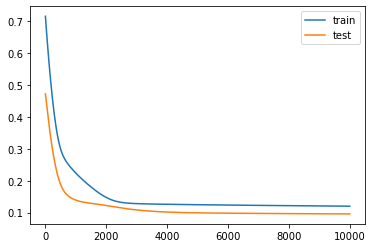

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [37]:
y_predict = model.predict(xs_test)

In [38]:
y_predict

array([[-0.6626538 ],
       [-0.8424475 ],
       [-1.0092505 ],
       [-0.9360556 ],
       [-0.7835165 ],
       [-0.6200858 ],
       [-0.4644222 ],
       [-0.34612888],
       [-0.29424828],
       [-0.31793422],
       [-0.39909637],
       [-0.53574616],
       [-0.7072365 ],
       [-0.8748739 ]], dtype=float32)

In [39]:
y_train_inv = cnt__transformer.inverse_transform(ys_train.reshape(1, -1))
y_test_inv = cnt__transformer.inverse_transform(ys_test.reshape(1, -1))
y_pred_inv = cnt__transformer.inverse_transform(y_predict)

In [40]:
y_pred_inv

array([[26.09631 ],
       [21.78126 ],
       [17.777988],
       [19.534666],
       [23.195602],
       [27.11794 ],
       [30.853867],
       [33.69291 ],
       [34.93804 ],
       [34.36958 ],
       [32.421688],
       [29.142092],
       [25.026323],
       [21.003027]], dtype=float32)

In [41]:
y_test_inv

array([[29., 35., 28., 40., 27., 26., 40., 49., 58., 46., 46., 34., 23.,
        13.]])

## Inference

In [ ]:
#test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
#xs_test, ys_test = creat_ds(test, test.value, time_step=Time_Step)
#y_predict = model.predict(xs_test)

In [43]:
category= 'Alkoholunfälle'
type= 'insgesamt'
year= '2021'
month= '01'


In [75]:
def main():
    if category == 'Alkoholunfälle':
        
        if type == 'insgesamt':
            month_ls = [1,2,3,4,5,6,7,8,9,10,11,12,1]
            year_ls = [2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021]
            value_ls = list(df['value'][-12:])
            #print(value_ls)

            value_ls.append(0)
            #print()
            #print()
            inf_df = pd.DataFrame(list(zip(year_ls, month_ls, value_ls)), columns =['year', 'month', 'value'])
            #print(inf_df)
            xs_inf, ys_inf = creat_ds(inf_df, inf_df.value, time_step=Time_Step)
            #print()
            #print(xs_inf)
            #print()
            #print(ys_inf)
            y_predict_inf = model.predict(xs_inf)
            y_pred_inv = cnt__transformer.inverse_transform(y_predict_inf)
    print(y_pred_inv[0][0])         
          
                 
          

In [76]:
main()

12.448929


- https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://www.youtube.com/watch?v=xaIA83x5Icg
- https://www.youtube.com/watch?v=uw6zYLbCGkY